使用{mlr3verse}进行模型解释。

In [74]:
library(mlr3verse)
library(mlr3extralearners)

# 选择特征
tsk_german <- tsk("german_credit")$select(
  cols = c(
    "duration", "amount", "age", "status", "savings", "purpose",
    "credit_history", "property", "employment_duration", "other_debtors"
  )
)

# 数据集划分
split <- partition(tsk_german)

# 定义并训练模型
lrn_gbm <- lrn("classif.gbm", predict_type = "prob")
lrn_gbm$train(tsk_german, row_ids = split$train)

Distribution not specified, assuming bernoulli ...


# {imp}包

In [75]:
library(iml)

# 提取测试集特征和目标变量
credit_x <- tsk_german$data(rows = split$test, cols = tsk_german$feature_names)
credit_y <- tsk_german$data(rows = split$test, cols = tsk_german$target_names)

# 构建IML解释器
predictor <- Predictor$new(
  model = lrn_gbm,
  data = credit_x,
  y = credit_y
)

## 特征重要性

In [76]:
library(data.table)

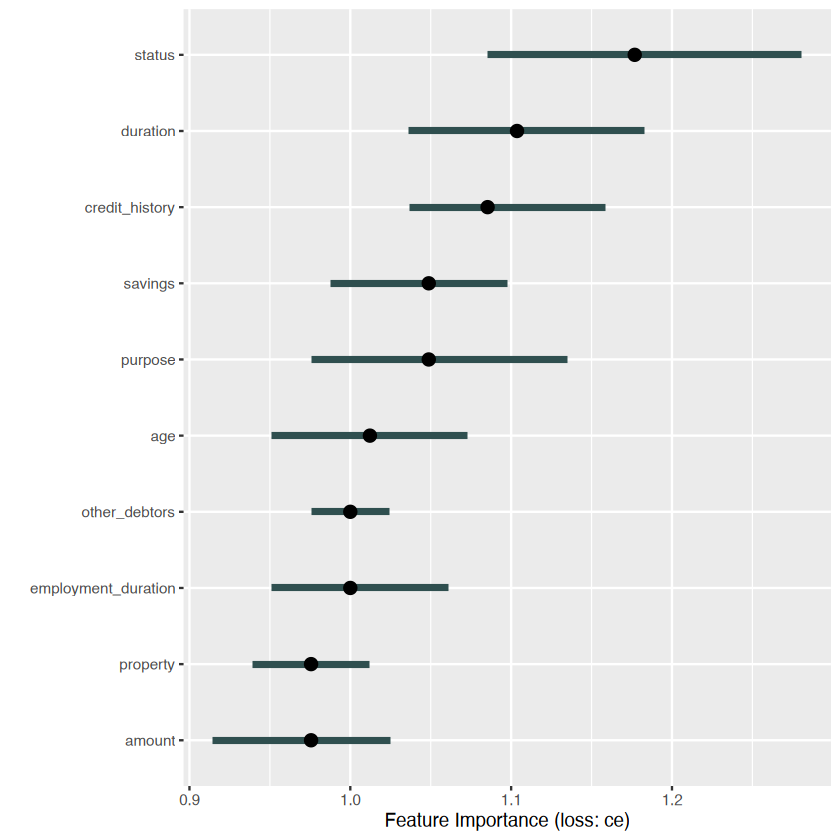

In [77]:
importance <- FeatureImp$new(
  predictor,
  loss = "ce",
  n.repetitions = 100
)
importance$plot()

## 特征效应

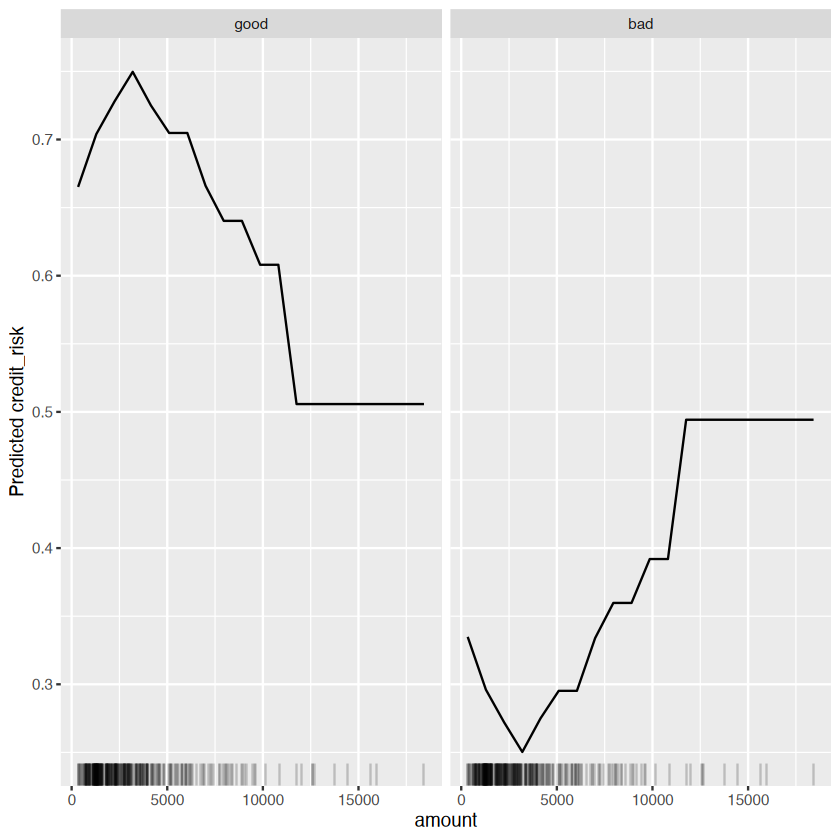

In [78]:
effect_pdp <- FeatureEffect$new(
  predictor,
  feature = "amount",
  method = "pdp"
)
effect_pdp$plot()

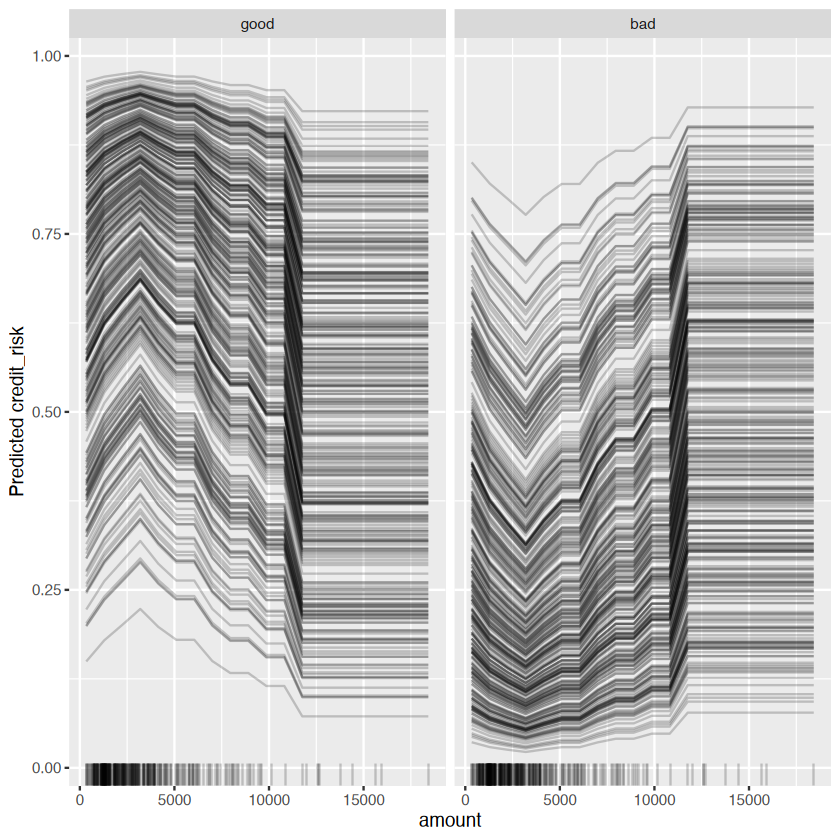

In [79]:
effect_ice <- FeatureEffect$new(
  predictor,
  feature = "amount",
  method = "ice"
)
effect_ice$plot()

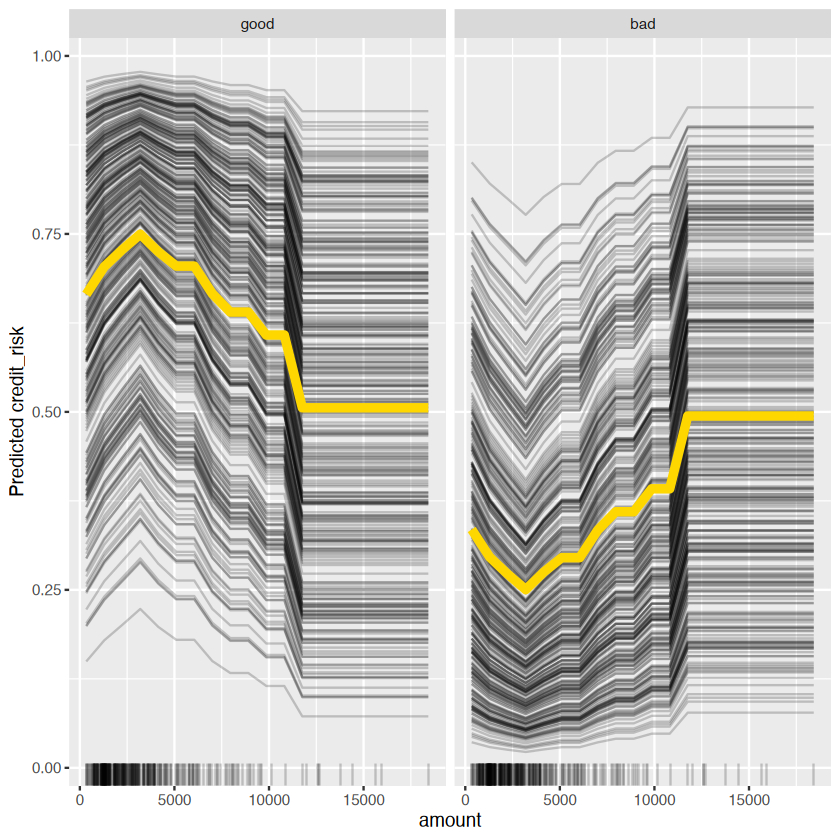

In [80]:
effect <- FeatureEffect$new(
  predictor,
  feature = "amount",
  method = "pdp+ice"
)
effect$plot()

## 替代模型

### 全局替代模型

In [81]:
tree_surrogate <- TreeSurrogate$new(predictor, maxdepth = 2L)

In [102]:
pred_surrogate <- tree_surrogate$predict(credit_x, type = "class")$.class
pred_surrogate <- factor(pred_surrogate, levels = c("good", "bad"))
pred_gbm  <- lrn_gbm$predict_newdata(credit_x)$response
confusion <- mlr3measures::confusion_matrix(
  pred_surrogate, pred_gbm,
  positive = "good"
)
confusion

# truth
# response good bad
#     good  270  11
#     bad    22  27
# acc :  0.9000; ce  :  0.1000; dor :  30.1240; f1  :  0.9424 
# fdr :  0.0391; fnr :  0.0753; fomr:  0.4490; fpr :  0.2895 
# mcc :  0.5702; npv :  0.5510; ppv :  0.9609; tnr :  0.7105 
# tpr :  0.9247

ERROR: Error in assert_binary(truth, response = response, positive = positive, : Assertion on 'truth' failed: Must have length >= 1, but has length 0.


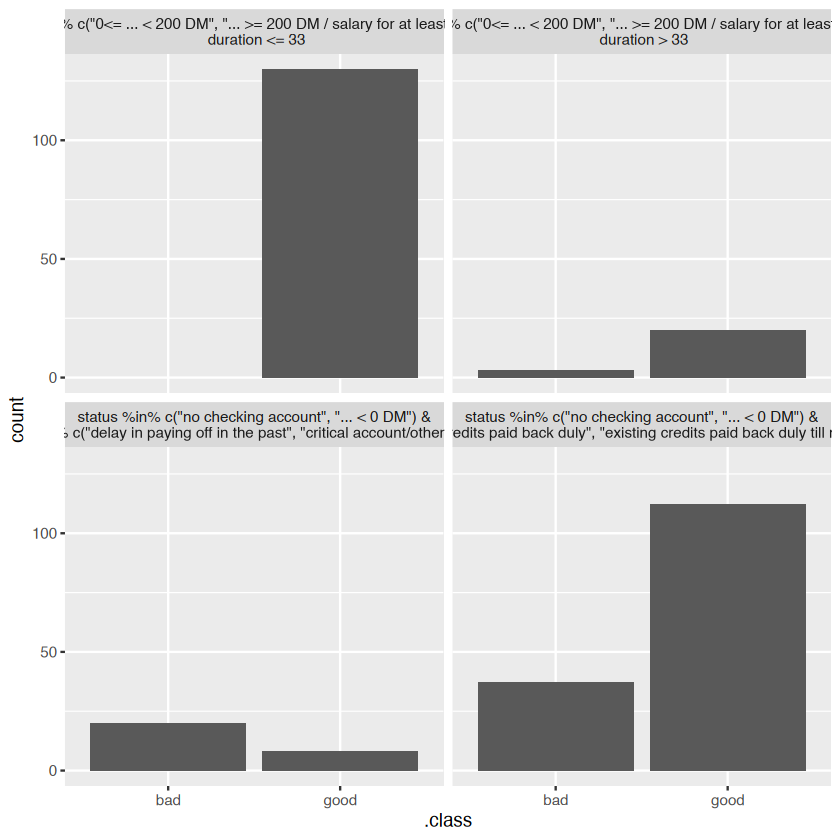

In [83]:
tree_surrogate$plot()

In [84]:
partykit::print.party(tree_surrogate$tree)

# [1] root
# |   [2] status in no checking account, ... < 0 DM
# |   |   [3] duration <= 27: *
# |   |   [4] duration > 27: *
# |   [5] status in 0<= ... < 200 DM, ... >= 200 DM / salary for at least 1 year
# |   |   [6] credit_history in delay in paying off in the past, critical account/other credits elsewhere, existing credits paid back duly till now: *
# |   |   [7] credit_history in no credits taken/all credits paid back duly, all credits at this bank paid back duly: *

[1] root
|   [2] status in no checking account, ... < 0 DM
|   |   [3] credit_history in delay in paying off in the past, critical account/other credits elsewhere: *
|   |   [4] credit_history in no credits taken/all credits paid back duly, existing credits paid back duly till now, all credits at this bank paid back duly: *
|   [5] status in 0<= ... < 200 DM, ... >= 200 DM / salary for at least 1 year
|   |   [6] duration <= 33: *
|   |   [7] duration > 33: *


下面是分界线：

In [117]:
library(iml)

# 提取测试集特征和目标变量
credit_x <- tsk_german$data(rows = split$test, cols = tsk_german$feature_names)
credit_y <- tsk_german$data(rows = split$test, cols = tsk_german$target_names)

# 构建IML解释器
predictor <- Predictor$new(
  model = lrn_gbm,
  data = credit_x,
  y = credit_y
)

In [118]:
tree_surrogate <- TreeSurrogate$new(predictor, maxdepth = 3)

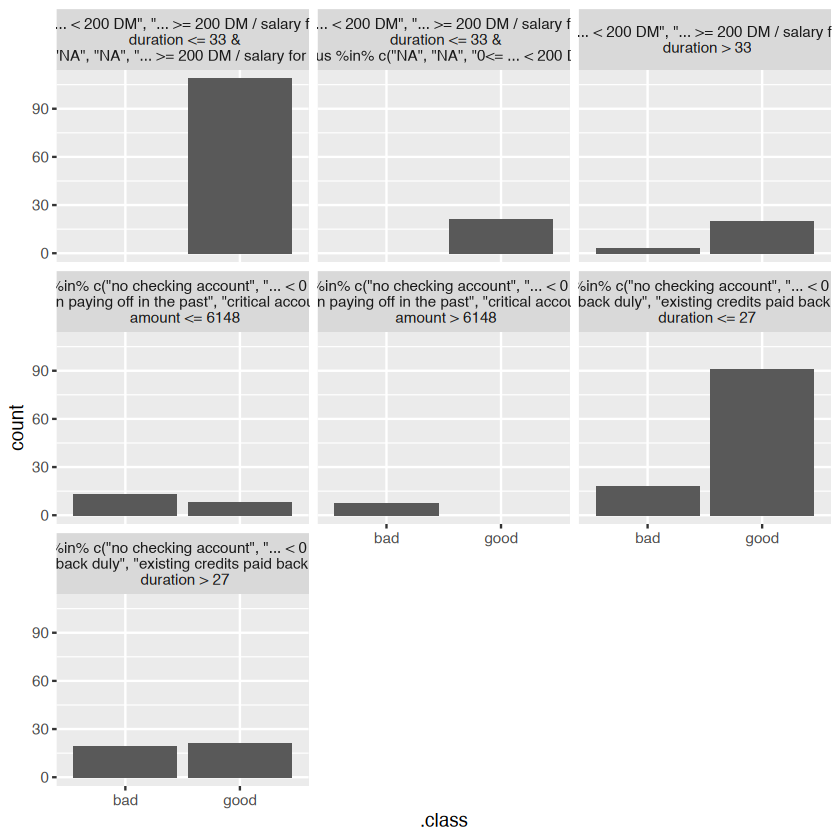

In [119]:
tree_surrogate$plot()

In [120]:
pred_surrogate <- tree_surrogate$predict(credit_x, type = "class")$.class
pred_surrogate

[1] "good" "good" "good" "good" "good" "good" "bad"  "good" "good" "good"
 [11] "good" "good" "good" "good" "good" "good" "good" "good" "good" "bad" 
 [21] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
 [31] "good" "good" "bad"  "bad"  "good" "good" "good" "good" "good" "good"
 [41] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
 [51] "good" "good" "bad"  "good" "good" "good" "good" "good" "good" "good"
 [61] "good" "good" "good" "good" "good" "good" "good" "bad"  "good" "good"
 [71] "bad"  "good" "good" "good" "good" "good" "good" "good" "good" "good"
 [81] "good" "bad"  "good" "good" "good" "good" "bad"  "good" "good" "good"
 [91] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[101] "good" "good" "good" "good" "good" "good" "good" "good" "good" "bad" 
[111] "good" "good" "good" "good" "good" "good" "good" "good" "bad"  "good"
[121] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[131] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[141] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[151] "good" "good" "good" "good" "good" "good" "good" "bad"  "good" "good"
[161] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[171] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[181] "good" "good" "good" "good" "good" "good" "good" "good" "good" "bad" 
[191] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[201] "bad"  "bad"  "bad"  "bad"  "bad"  "good" "good" "good" "good" "good"
[211] "good" "good" "good" "bad"  "good" "good" "good" "good" "good" "good"
[221] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[231] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[241] "bad"  "bad"  "good" "good" "good" "bad"  "good" "good" "bad"  "good"
[251] "good" "good" "good" "good" "good" "good" "good" "good" "good" "bad" 
[261] "good" "good" "good" "good" "good" "good" "good" "bad"  "good" "good"
[271] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[281] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[291] "good" "good" "good" "good" "good" "good" "good" "good" "bad"  "good"
[301] "good" "good" "good" "bad"  "good" "good" "good" "good" "good" "bad" 
[311] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"
[321] "good" "good" "good" "good" "good" "good" "good" "good" "good" "good"

In [121]:
pred_surrogate <- tree_surrogate$predict(credit_x, type = "class")$.class
pred_surrogate <- factor(pred_surrogate, levels = c("good", "bad"))
pred_gbm  <- lrn_gbm$predict_newdata(credit_x)$response
confusion <- mlr3measures::confusion_matrix(
  pred_surrogate, pred_gbm,
  positive = "good"
)
confusion

        truth
response good bad
    good  262   8
    bad    40  20
acc :  0.8545; ce  :  0.1455; dor :  16.3750; f1  :  0.9161 
fdr :  0.0296; fnr :  0.1325; fomr:  0.6667; fpr :  0.2857 
mcc :  0.4204; npv :  0.3333; ppv :  0.9704; tnr :  0.7143 
tpr :  0.8675 

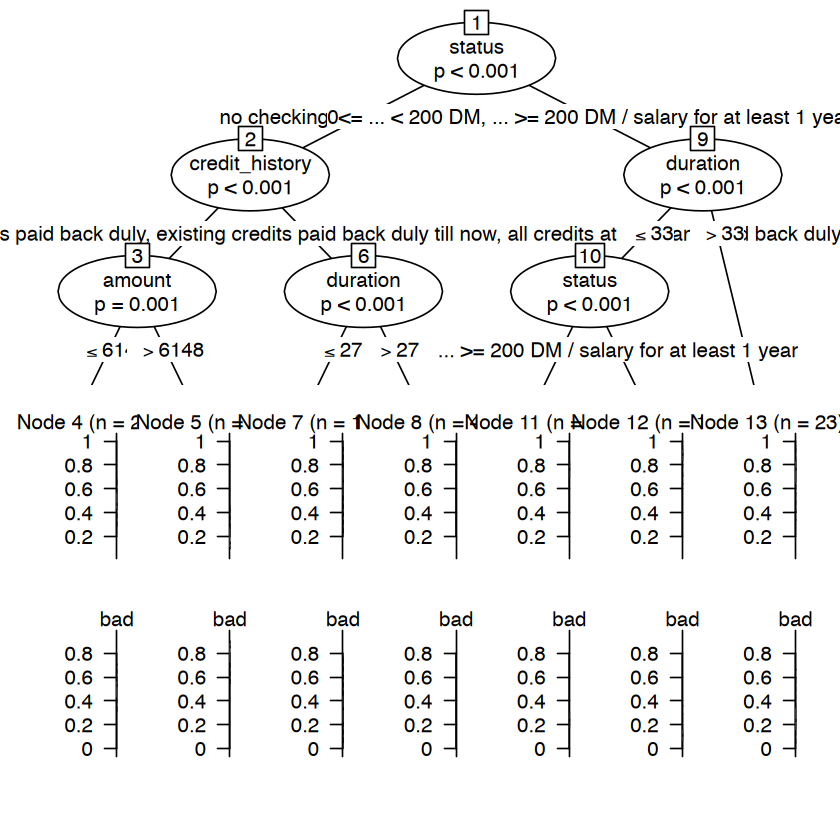

In [124]:
plot(tree_surrogate$tree)

In [123]:
partykit::print.party(tree_surrogate$tree)

[1] root
|   [2] status in no checking account, ... < 0 DM
|   |   [3] credit_history in delay in paying off in the past, critical account/other credits elsewhere
|   |   |   [4] amount <= 6148: *
|   |   |   [5] amount > 6148: *
|   |   [6] credit_history in no credits taken/all credits paid back duly, existing credits paid back duly till now, all credits at this bank paid back duly
|   |   |   [7] duration <= 27: *
|   |   |   [8] duration > 27: *
|   [9] status in 0<= ... < 200 DM, ... >= 200 DM / salary for at least 1 year
|   |   [10] duration <= 33
|   |   |   [11] status in 0<= ... < 200 DM: *
|   |   |   [12] status in ... >= 200 DM / salary for at least 1 year: *
|   |   [13] duration > 33: 
|   |       $criterion
|   |                          age      amount credit_history   duration
|   |       statistic   0.05677193  7.38058908      4.0435203  2.8913781
|   |       p.value     0.99999970  0.05779734      0.9308271  0.5680528
|   |       criterion -15.02616791 -0.05953489  

## 局部替代模型

In [87]:
Charlie <- tsk_german$data(rows = 127L, cols = tsk_german$feature_names)
gbm_predict <- predictor$predict(Charlie)
gbm_predict

# good     bad     
# 1 0.681367 0.318633

good,bad
<dbl>,<dbl>
0.6580401,0.3419599


In [88]:
predictor$class <- "good" # explain the 'good' class
local_surrogate <- LocalModel$new(
  predictor,
  Charlie,
  gower.power = 0.1,
  k = 2
)

In [89]:
c(gbm = gbm_predict[[1]], local = local_surrogate$predict()[[1]])

# gbm     local 
# 0.6813670 0.6461494

gbm     local 
0.6580401 0.6307507

In [90]:
# 查找Charlie的10个最近邻
ind_10nn <- gower::gower_topn(Charlie, credit_x, n = 10)$index[, 1]
Charlie_10nn <- credit_x[ind_10nn, ]

# 预测最近邻的概率
gbm_pred_10nn <- predictor$predict(Charlie_10nn)[[1]]
local_pred_10nn <- local_surrogate$predict(Charlie_10nn)[[1]]

# 计算两者预测概率的平均绝对误差
mean(abs(gbm_pred_10nn - local_pred_10nn))

# [1] 0.09816783

[1] 0.1043648

In [91]:
local_surrogate$results[, c("feature.value", "effect")]

# feature.value              effect     
# duration                   duration=12                -0.02150842
# status=no checking account status=no checking account -0.10311406

,feature.value,effect
,<chr>,<dbl>
duration,duration=12,-0.02216865
status=no checking account,status=no checking account,-0.12344513


## Shapely值

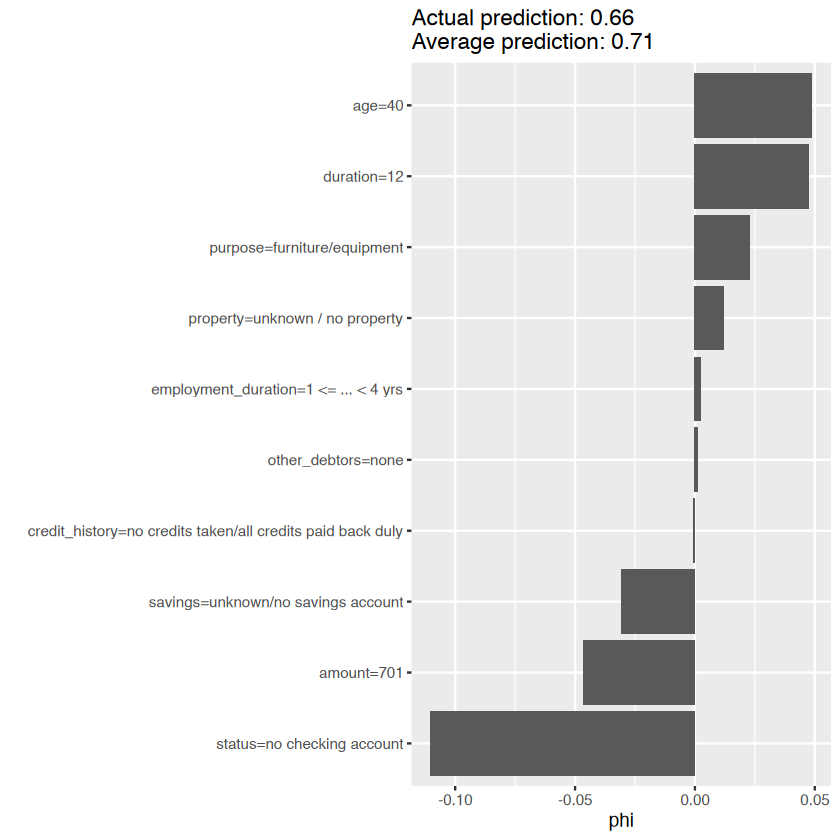

In [92]:
shapley <- Shapley$new(
  predictor,
  x.interest = as.data.frame(Charlie),
  sample.size = 1000
)
shapley$plot(title = "Shapley values for Charlie")

# {counterfactuals}包

## What-If 法

In [ ]:
library(counterfactuals)

# 创建WhatIfClassif对象，设置生成1个反事实样本
whatif <- WhatIfClassif$new(predictor, n_counterfactuals = 1L)

# 查找使预测类别为"good"，概率在0.75到1之间的反事实
cfe <- whatif$find_counterfactuals(
  Charlie,
  desired_class = "good",
  desired_prob = c(0.75, 1)
)

# 展示反事实样本及与原样本的差异
data.frame(cfe$evaluate(show_diff = TRUE))

# age amount credit_history duration employment_duration other_debtors property
# 1 -12 75     NA             NA       NA                  NA            NA      
#   purpose savings status                                     dist_x_interest
# 1 NA      NA      ... >= 200 DM / salary for at least 1 year 0.1226369      
#   no_changed dist_train dist_target minimality
# 1 3          0          0           2

age,amount,credit_history,duration,employment_duration,other_debtors,property,purpose,savings,status,dist_x_interest,no_changed,dist_train,dist_target,minimality
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
-12,75,NA,NA,NA,NA,NA,NA,NA,... >= 200 DM / salary for at least 1 year,0.1226369,3,0,0,2


## MOC 法

In [130]:
moc <- MOCClassif$new(
  predictor,
  epsilon = 0,
  n_generations = 30L,
  fixed_features = "age"
)
cfe_multi <- moc$find_counterfactuals(
  Charlie,
  desired_class = "good",
  desired_prob = c(0.75, 1)
)

INFO  [16:10:05.904] [bbotk] Evaluating 20 configuration(s)
INFO  [16:10:05.980] [bbotk] Result of batch 1:
INFO  [16:10:05.986] [bbotk]  amount                              credit_history duration
INFO  [16:10:05.986] [bbotk]     701    existing credits paid back duly till now        9
INFO  [16:10:05.986] [bbotk]   13573     all credits at this bank paid back duly       63
INFO  [16:10:05.986] [bbotk]     701             delay in paying off in the past        4
INFO  [16:10:05.986] [bbotk]     701    existing credits paid back duly till now       46
INFO  [16:10:05.986] [bbotk]     701 no credits taken/all credits paid back duly       63
INFO  [16:10:05.986] [bbotk]    2705             delay in paying off in the past       66
INFO  [16:10:05.986] [bbotk]    6054 no credits taken/all credits paid back duly       12
INFO  [16:10:05.986] [bbotk]     701    critical account/other credits elsewhere       61
INFO  [16:10:05.986] [bbotk]     701 no credits taken/all credits paid back duly  

`x_interest` was removed from results.



In [ ]:
cfe_multi$subset_to_valid()
cfe_multi

# 3 Counterfactual(s) 
 
# Desired class: good 
# Desired predicted probability range: [0.75, 1] 
 
# Head: 
#      age amount                              credit_history duration
#    <int>  <int>                                      <fctr>    <int>
# 1:    40    701 no credits taken/all credits paid back duly        7
# 2:    40    701 no credits taken/all credits paid back duly       12
# 3:    40    701 no credits taken/all credits paid back duly        7
#    employment_duration other_debtors              property             purpose
#                 <fctr>        <fctr>                <fctr>              <fctr>
# 1:    1 <= ... < 4 yrs          none unknown / no property furniture/equipment
# 2:    1 <= ... < 4 yrs          none unknown / no property furniture/equipment
# 3:    1 <= ... < 4 yrs     guarantor unknown / no property furniture/equipment
#                       savings                                     status
#                        <fctr>                                     <fctr>
# 1: unknown/no savings account                        no checking account
# 2: unknown/no savings account ... >= 200 DM / salary for at least 1 year
# 3: unknown/no savings account                                 ... < 0 DM

3 Counterfactual(s) 
 
Desired class: good 
Desired predicted probability range: [0.75, 1] 
 
Head: 
     age amount                              credit_history duration
   <int>  <int>                                      <fctr>    <int>
1:    40    701 no credits taken/all credits paid back duly        7
2:    40    701 no credits taken/all credits paid back duly       12
3:    40    701 no credits taken/all credits paid back duly        7
   employment_duration other_debtors              property             purpose
                <fctr>        <fctr>                <fctr>              <fctr>
1:    1 <= ... < 4 yrs          none unknown / no property furniture/equipment
2:    1 <= ... < 4 yrs          none unknown / no property furniture/equipment
3:    1 <= ... < 4 yrs     guarantor unknown / no property furniture/equipment
                      savings                                     status
                       <fctr>                                     <fctr>
1: unknown/no

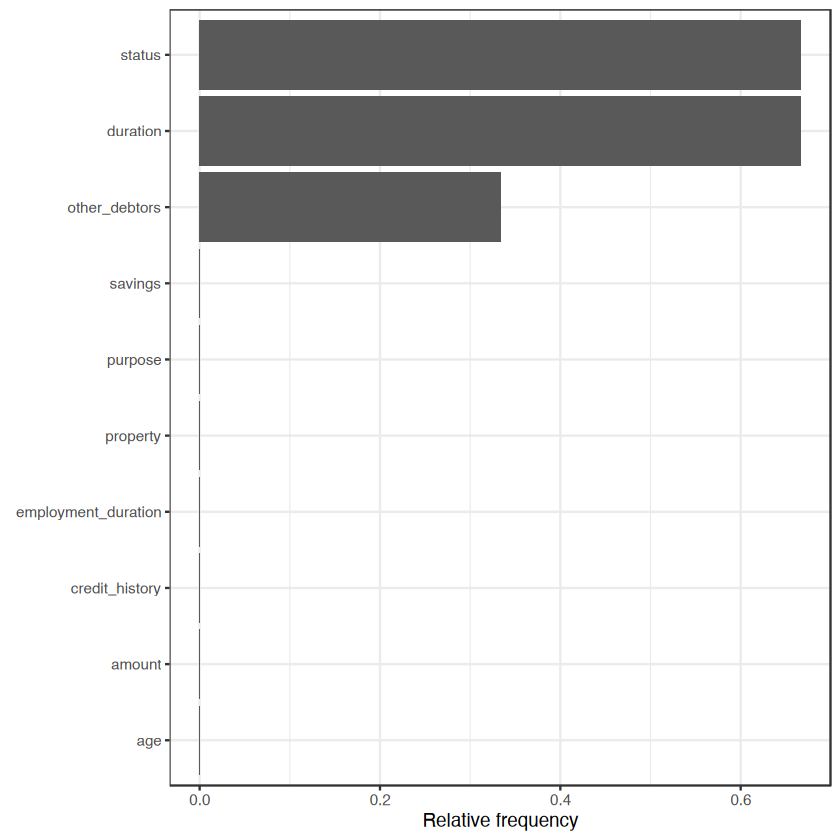

In [135]:
cfe_multi$plot_freq_of_feature_changes()

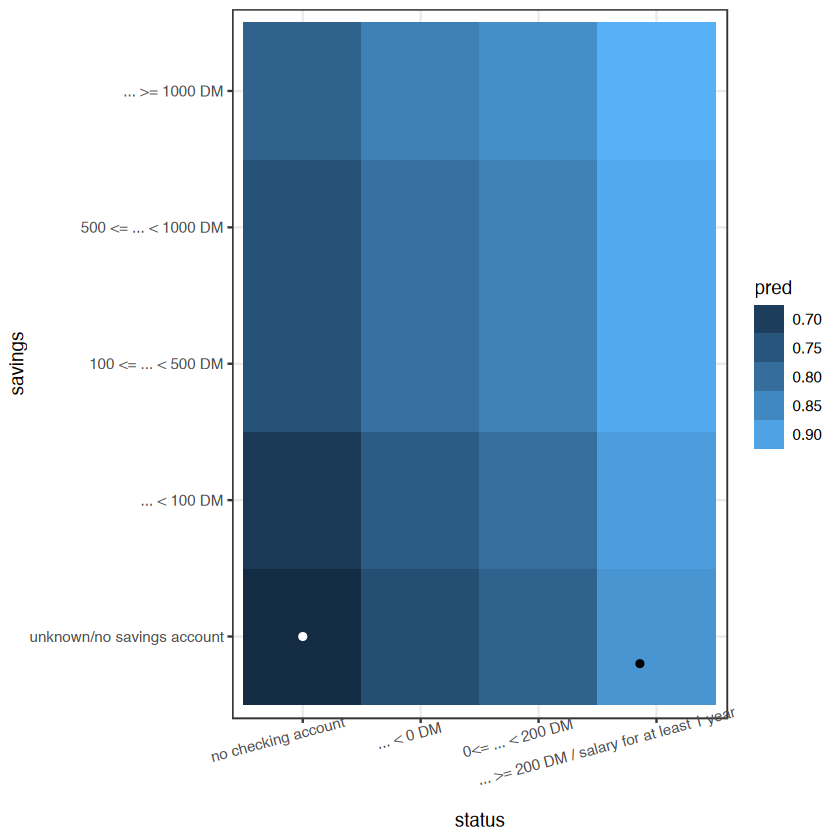

In [ ]:
cfe_multi$plot_surface(feature_names = c("status", "savings")) +
  theme(axis.text.x = element_text(angle = 15, hjust = .7))

# {DALEX} 包

In [138]:
library(DALEX)
library(DALEXtra)

gbm_exp <- DALEXtra::explain_mlr3(
  lrn_gbm,
  data = credit_x,
  y = as.numeric(credit_y$credit_risk == "bad"),
  label = "GBM Credit",
  colorize = FALSE
)

gbm_exp

Preparation of a new explainer is initiated
  -> model label       :  GBM Credit 
  -> data              :  330  rows  10  cols 
  -> target variable   :  330  values 
  -> predict function  :  yhat.LearnerClassif  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.23.0 , task classification (  default  ) 
  -> predicted values  :  numerical, min =  0.02542045 , mean =  0.2945186 , max =  0.900371  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.8667717 , mean =  0.02669351 , max =  0.8995445  
  A new explainer has been created!  


Model label:  GBM Credit 
Model class:  LearnerClassifGBM,LearnerClassif,Learner,R6 
Data head  :
  age amount                              credit_history duration
1  22   5951 no credits taken/all credits paid back duly       48
2  53   2835 no credits taken/all credits paid back duly       24
  employment_duration other_debtors              property             purpose
1    1 <= ... < 4 yrs          none unknown / no property furniture/equipment
2            >= 7 yrs          none          car or other          car (used)
                     savings                                     status
1 unknown/no savings account                                 ... < 0 DM
2        100 <= ... < 500 DM ... >= 200 DM / salary for at least 1 year

## 全局 EMA

In [ ]:
perf_credit <- model_performance(gbm_exp)
perf_credit

# Measures for:  classification
# recall     : 0.3962264 
# precision  : 0.7 
# f1         : 0.5060241 
# accuracy   : 0.7515152 
# auc        : 0.8175539

# Residuals:
#         0%        10%        20%        30%        40%        50%        60% 
# -0.8667717 -0.3983265 -0.2830293 -0.2004857 -0.1590699 -0.1093601 -0.0639378 
#        70%        80%        90%       100% 
#  0.2919533  0.4894076  0.6572512  0.8995445

Measures for:  classification
recall     : 0.3962264 
precision  : 0.7 
f1         : 0.5060241 
accuracy   : 0.7515152 
auc        : 0.8175539

Residuals:
        0%        10%        20%        30%        40%        50%        60% 
-0.8667717 -0.3983265 -0.2830293 -0.2004857 -0.1590699 -0.1093601 -0.0639378 
       70%        80%        90%       100% 
 0.2919533  0.4894076  0.6572512  0.8995445 

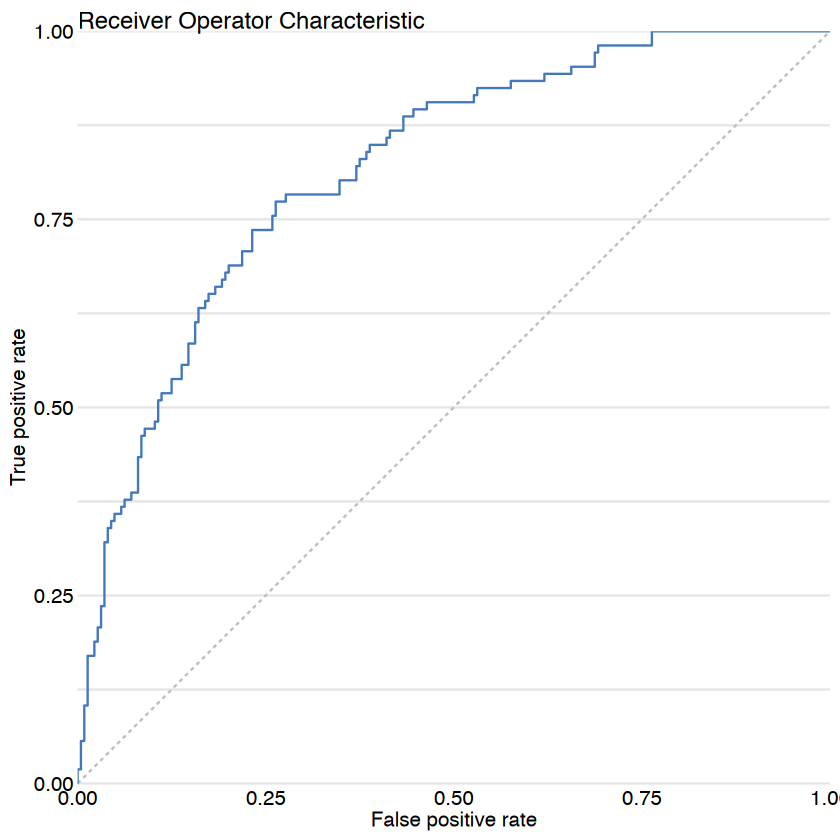

In [141]:
old_theme <- set_theme_dalex("ema")
plot(perf_credit, geom = "roc")

In [ ]:
gbm_effect <- model_parts(gbm_exp)
head(gbm_effect)

# variable            permutation dropout_loss label     
# 1 _full_model_        0           0.1824461    GBM Credit
# 2 other_debtors       0           0.1834569    GBM Credit
# 3 property            0           0.1870831    GBM Credit
# 4 age                 0           0.1879001    GBM Credit
# 5 employment_duration 0           0.1900943    GBM Credit
# 6 savings             0           0.1981258    GBM Credit

,variable,permutation,dropout_loss,label
,<chr>,<dbl>,<dbl>,<chr>
1,_full_model_,0,0.1824461,GBM Credit
2,other_debtors,0,0.1834569,GBM Credit
3,property,0,0.1870831,GBM Credit
4,age,0,0.1879001,GBM Credit
5,employment_duration,0,0.1900943,GBM Credit
6,savings,0,0.1981258,GBM Credit


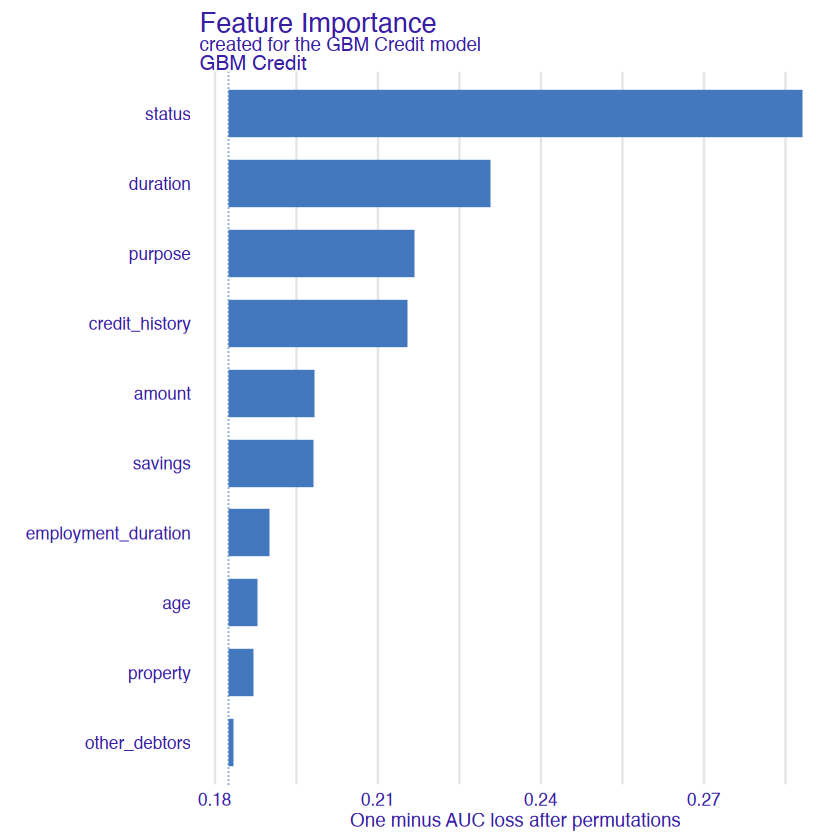

In [143]:
plot(gbm_effect, show_boxplots = FALSE)

In [ ]:
gbm_profiles <- model_profile(gbm_exp)
gbm_profiles

# Top profiles    : 
#    _vname_    _label_ _x_    _yhat_ _ids_
# 1 duration GBM Credit   4 0.1855367     0
# 2 duration GBM Credit   6 0.1855367     0
# 3 duration GBM Credit   7 0.1855367     0
# 4 duration GBM Credit   8 0.1855367     0
# 5 duration GBM Credit   9 0.2422180     0
# 6 duration GBM Credit  10 0.2422180     0

Warning message in FUN(X[[i]], ...):
"Variable: < amount > has more than 201 unique values and all of them will be used as variable splits in calculating variable profiles. Use the `variable_splits` parameter to mannualy change this behaviour. If you believe this warning to be a false positive, raise issue at <https://github.com/ModelOriented/ingredients/issues>."


Top profiles    : 
   _vname_    _label_ _x_    _yhat_ _ids_
1 duration GBM Credit   4 0.1855367     0
2 duration GBM Credit   6 0.1855367     0
3 duration GBM Credit   7 0.1855367     0
4 duration GBM Credit   8 0.1855367     0
5 duration GBM Credit   9 0.2422180     0
6 duration GBM Credit  10 0.2422180     0

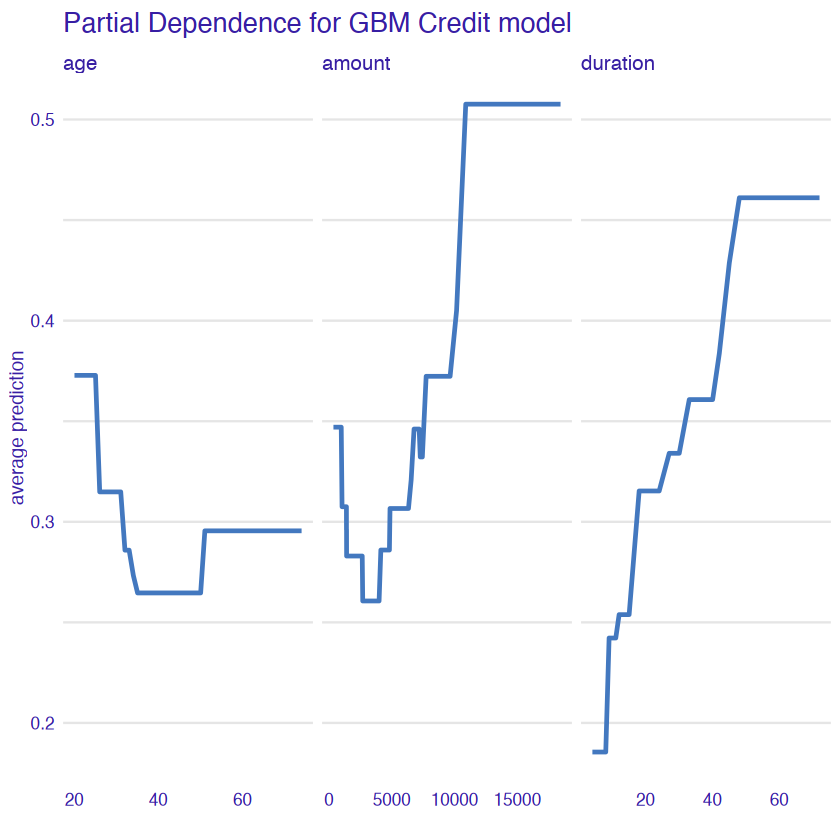

In [145]:
plot(gbm_profiles) +
  theme(legend.position = "top") +
  ggtitle("Partial Dependence for GBM Credit model", "")

## 局部 EMA

In [ ]:
predict(gbm_exp, Charlie)

# bad 
# 0.3419599

bad 
0.3419599

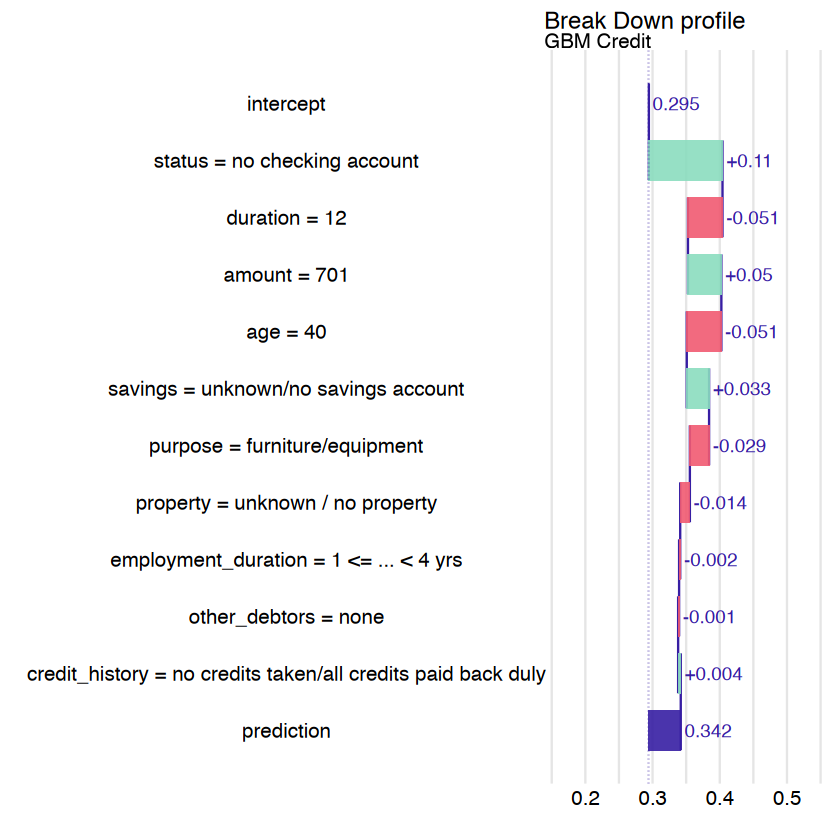

In [147]:
plot(predict_parts(gbm_exp, new_observation = Charlie))

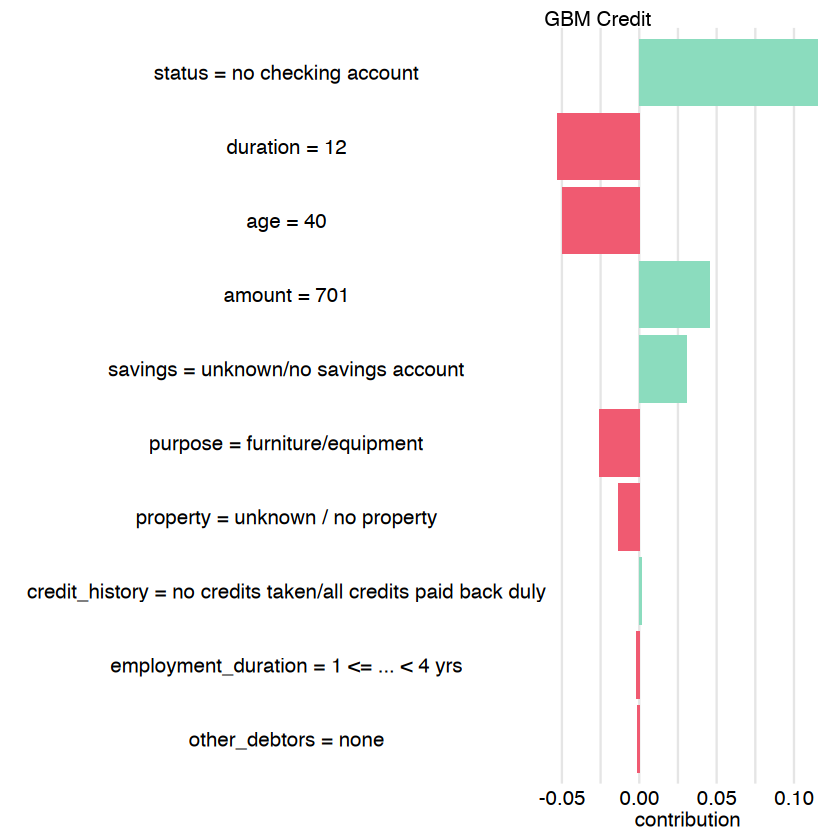

In [148]:
plot(
  predict_parts(
    gbm_exp,
    new_observation = Charlie,
    type = "shap"
  ),
  show_boxplots = FALSE
)

Warning message in FUN(X[[i]], ...):
"Variable: < amount > has more than 201 unique values and all of them will be used as variable splits in calculating variable profiles. Use the `variable_splits` parameter to mannualy change this behaviour. If you believe this warning to be a false positive, raise issue at <https://github.com/ModelOriented/ingredients/issues>."


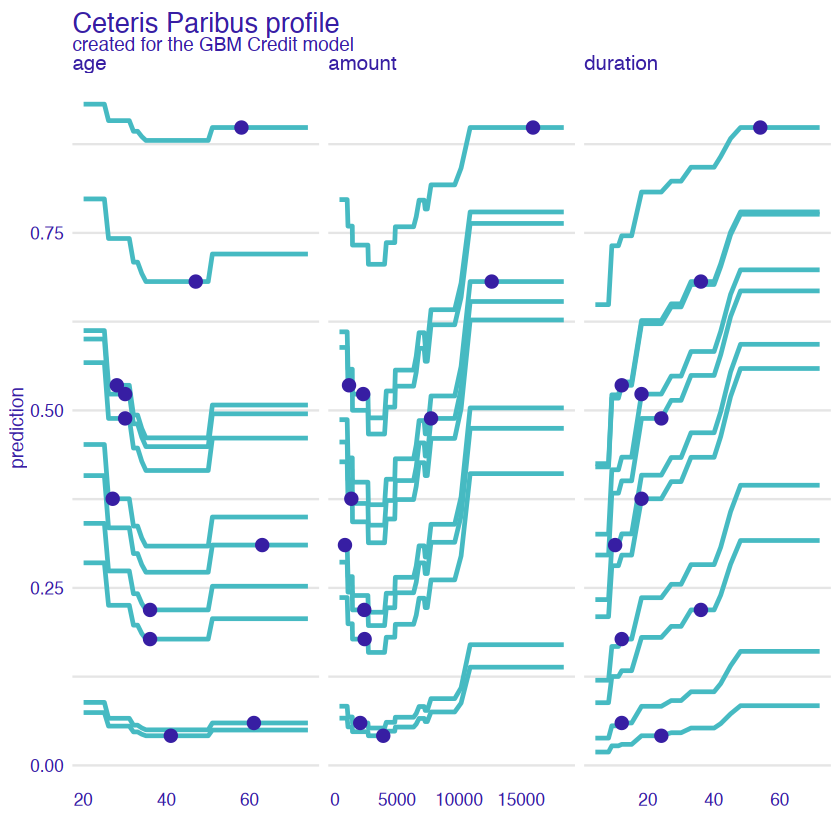

In [149]:
plot(predict_profile(gbm_exp,  credit_x[30:40, ]))

# 练习

## 练习1

In [6]:
library(DALEX)

Welcome to DALEX (version: 2.4.3).
Find examples and detailed introduction at: http://ema.drwhy.ai/



Attaching package: 'DALEX'


The following object is masked from 'package:dplyr':

    explain




In [1]:
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [14]:
fifa %>% glimpse()

Rows: 5,000
Columns: 42
$ nationality                <fct> Argentina, Portugal, Brazil, Slovenia, Belg~
$ overall                    <dbl> 94, 93, 92, 91, 91, 91, 90, 90, 90, 90, 89,~
$ potential                  <dbl> 94, 93, 92, 93, 91, 91, 93, 91, 90, 90, 95,~
$ wage_eur                   <dbl> 565000, 405000, 290000, 125000, 470000, 370~
$ value_eur                  <dbl> 95500000, 58500000, 105500000, 77500000, 90~
$ age                        <dbl> 32, 34, 27, 26, 28, 28, 27, 27, 33, 27, 20,~
$ height_cm                  <dbl> 170, 187, 175, 188, 175, 181, 187, 193, 172~
$ weight_kg                  <dbl> 72, 83, 68, 87, 74, 70, 85, 92, 66, 71, 73,~
$ attacking_crossing         <dbl> 88, 84, 87, 13, 81, 93, 18, 53, 86, 79, 78,~
$ attacking_finishing        <dbl> 95, 94, 87, 11, 84, 82, 14, 52, 72, 90, 89,~
$ attacking_heading_accuracy <dbl> 70, 89, 62, 15, 61, 55, 11, 86, 55, 59, 77,~
$ attacking_short_passing    <dbl> 92, 83, 87, 43, 89, 92, 61, 78, 92, 84, 82,~
$ attacking_voll

In [15]:
df_fifa <- fifa %>%
  select(value_eur, age, starts_with("skill"))

df_fifa %>% glimpse()

Rows: 5,000
Columns: 7
$ value_eur          <dbl> 95500000, 58500000, 105500000, 77500000, 90000000, ~
$ age                <dbl> 32, 34, 27, 26, 28, 28, 27, 27, 33, 27, 20, 28, 25,~
$ skill_dribbling    <dbl> 97, 89, 96, 12, 95, 86, 21, 70, 87, 89, 91, 69, 80,~
$ skill_curve        <dbl> 93, 81, 88, 13, 83, 85, 18, 60, 85, 83, 79, 28, 78,~
$ skill_fk_accuracy  <dbl> 94, 76, 87, 14, 79, 83, 12, 70, 78, 69, 63, 28, 68,~
$ skill_long_passing <dbl> 92, 77, 81, 40, 83, 91, 63, 81, 88, 75, 70, 63, 83,~
$ skill_ball_control <dbl> 96, 92, 95, 30, 94, 91, 30, 76, 92, 89, 90, 71, 84,~


In [16]:
library(mlr3verse)

In [17]:
lts()

<DictionaryTuningSpaces> with 36 stored values
Keys: classif.glmnet.default, classif.glmnet.rbv1, classif.glmnet.rbv2,
  classif.kknn.default, classif.kknn.rbv1, classif.kknn.rbv2,
  classif.ranger.default, classif.ranger.rbv1, classif.ranger.rbv2,
  classif.rpart.default, classif.rpart.rbv1, classif.rpart.rbv2,
  classif.svm.default, classif.svm.rbv1, classif.svm.rbv2,
  classif.xgboost.default, classif.xgboost.rbv1, classif.xgboost.rbv2,
  regr.glmnet.default, regr.glmnet.rbv1, regr.glmnet.rbv2,
  regr.kknn.default, regr.kknn.rbv1, regr.kknn.rbv2,
  regr.ranger.default, regr.ranger.rbv1, regr.ranger.rbv2,
  regr.rpart.default, regr.rpart.rbv1, regr.rpart.rbv2,
  regr.svm.default, regr.svm.rbv1, regr.svm.rbv2, regr.xgboost.default,
  regr.xgboost.rbv1, regr.xgboost.rbv2

In [35]:
# 定义任务
tsk_fifa <- as_task_regr(df_fifa, target = "value_eur")

# 数据集划分
split_fifa <- mlr3::partition(tsk_fifa, ratio = 0.8)
tsk_train <- tsk_fifa$clone()$filter(split_fifa$train)
tsk_test  <- tsk_fifa$clone()$filter(split_fifa$test)

# 定义模型
lrn_ranger <- lrn("regr.ranger")

# 定义参数空间
lts_ranger <- lts("regr.ranger.rbv1")

# 调参
library(future)
plan("multisession", workers = 6)
instance <- tune(
  tuner = tnr("random_search"),
  learner = lrn_ranger,
  task = tsk_train,
  resampling = rsmp("cv", folds = 5),
  measures = msr("regr.mse"),
  search_space = lts_ranger,
  terminator = trm("evals", n_evals = 20),
)

INFO  [19:26:19.070] [bbotk] Starting to optimize 6 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=20, k=0]'
INFO  [19:26:19.094] [bbotk] Evaluating 1 configuration(s)
INFO  [19:26:19.097] [mlr3] Running benchmark with 5 resampling iterations
INFO  [19:26:19.876] [mlr3] Applying learner 'regr.ranger' on task 'df_fifa' (iter 1/5)
INFO  [19:26:19.925] [mlr3] Applying learner 'regr.ranger' on task 'df_fifa' (iter 2/5)
INFO  [19:26:20.033] [mlr3] Applying learner 'regr.ranger' on task 'df_fifa' (iter 3/5)
INFO  [19:26:20.162] [mlr3] Applying learner 'regr.ranger' on task 'df_fifa' (iter 4/5)
INFO  [19:26:20.300] [mlr3] Applying learner 'regr.ranger' on task 'df_fifa' (iter 5/5)
INFO  [19:26:21.211] [mlr3] Finished benchmark
INFO  [19:26:21.230] [bbotk] Result of batch 1:
INFO  [19:26:21.232] [bbotk]  min.node.size mtry.ratio num.trees replace respect.unordered.factors
INFO  [19:26:21.232] [bbotk]             66  0.6751236       788    TRUE                 

In [ ]:
instance$result %>% print()

# min.node.size mtry.ratio num.trees replace respect.unordered.factors
#            <int>      <num>     <int>  <lgcl>                    <char>
# 1:            18  0.3865324      1689    TRUE                     order
#    sample.fraction learner_param_vals  x_domain     regr.mse
#              <num>             <list>    <list>        <num>
# 1:       0.5670923          <list[7]> <list[6]> 3.344713e+13

   min.node.size mtry.ratio num.trees replace respect.unordered.factors
           <int>      <num>     <int>  <lgcl>                    <char>
1:            18  0.3865324      1689    TRUE                     order
   sample.fraction learner_param_vals  x_domain     regr.mse
             <num>             <list>    <list>        <num>
1:       0.5670923          <list[7]> <list[6]> 3.344713e+13


In [ ]:
# 选择最优参数
lrn_ranger$param_set$values <- instance$result_learner_param_vals
lrn_ranger$train(tsk_train)
pred_ranger <- lrn_ranger$predict(tsk_test)
pred_ranger$score(msr("regr.mse"))

# regr.mse: 37716330127416.9

regr.mse 
3.771633e+13

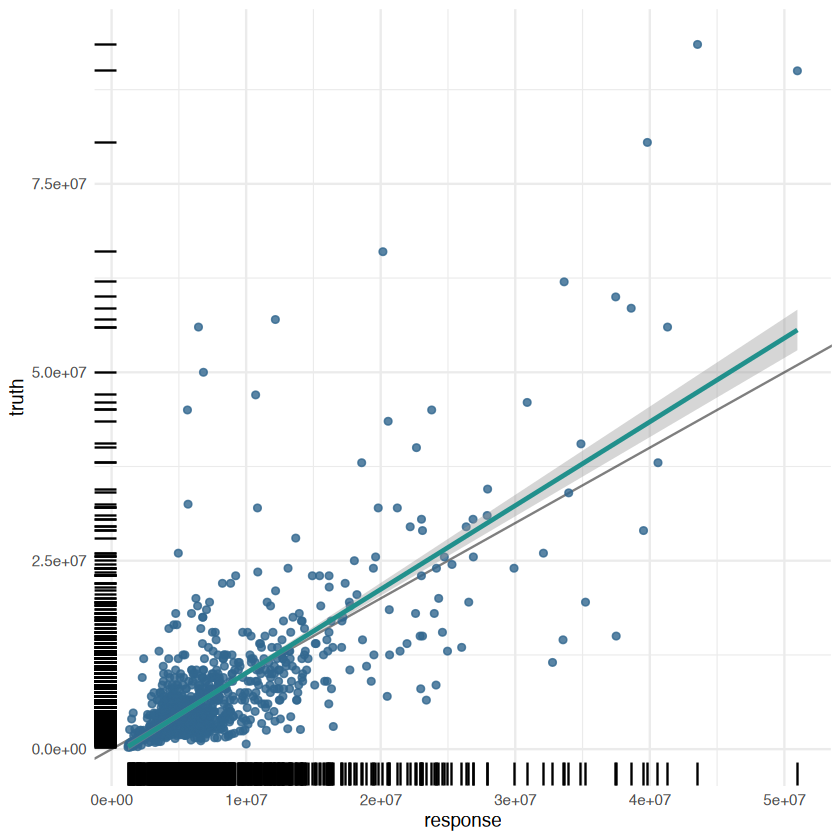

In [53]:
autoplot(pred_ranger)

## 练习2

In [56]:
# 加载IML包
library(iml)

# 先提取测试集特征和目标变量
test_features <- tsk_test$data(cols = tsk_fifa$feature_names)
test_target <- tsk_test$data(cols = tsk_fifa$target_names)

# 构建IML解释器
predictor <- Predictor$new(
  model = lrn_ranger,
  data = test_features,
  y = test_target
)

In [ ]:
importance <- FeatureImp$new(
  predictor,
  loss = "mse",
  n.repetitions = 100
)
importance

# Interpretation method:  FeatureImp 
# error function: mse

# Analysed predictor: 
# Prediction task: regression 


# Analysed data:
# Sampling from data.frame with 1000 rows and 6 columns.


# Head of results:
#              feature importance.05 importance importance.95 permutation.error
# 1 skill_ball_control      2.778614   2.923431      2.997389      1.102611e+14
# 2 skill_long_passing      1.445497   1.490076      1.543566      5.620022e+13
# 3    skill_dribbling      1.407729   1.460740      1.514533      5.509376e+13
# 4                age      1.097511   1.130424      1.159779      4.263543e+13
# 5  skill_fk_accuracy      1.098189   1.124927      1.150033      4.242813e+13
# 6        skill_curve      1.077303   1.104581      1.123871      4.166074e+13

Interpretation method:  FeatureImp 
error function: mse

Analysed predictor: 
Prediction task: regression 


Analysed data:
Sampling from data.frame with 1000 rows and 6 columns.


Head of results:
             feature importance.05 importance importance.95 permutation.error
1 skill_ball_control      2.778614   2.923431      2.997389      1.102611e+14
2 skill_long_passing      1.445497   1.490076      1.543566      5.620022e+13
3    skill_dribbling      1.407729   1.460740      1.514533      5.509376e+13
4                age      1.097511   1.130424      1.159779      4.263543e+13
5  skill_fk_accuracy      1.098189   1.124927      1.150033      4.242813e+13
6        skill_curve      1.077303   1.104581      1.123871      4.166074e+13

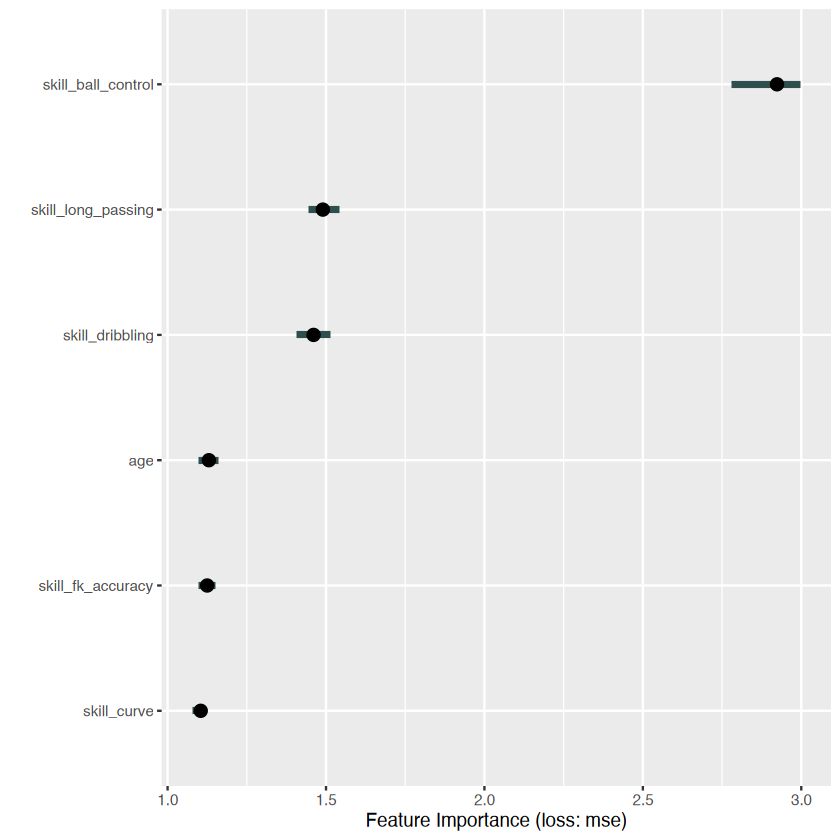

In [59]:
importance$plot()

## 练习3

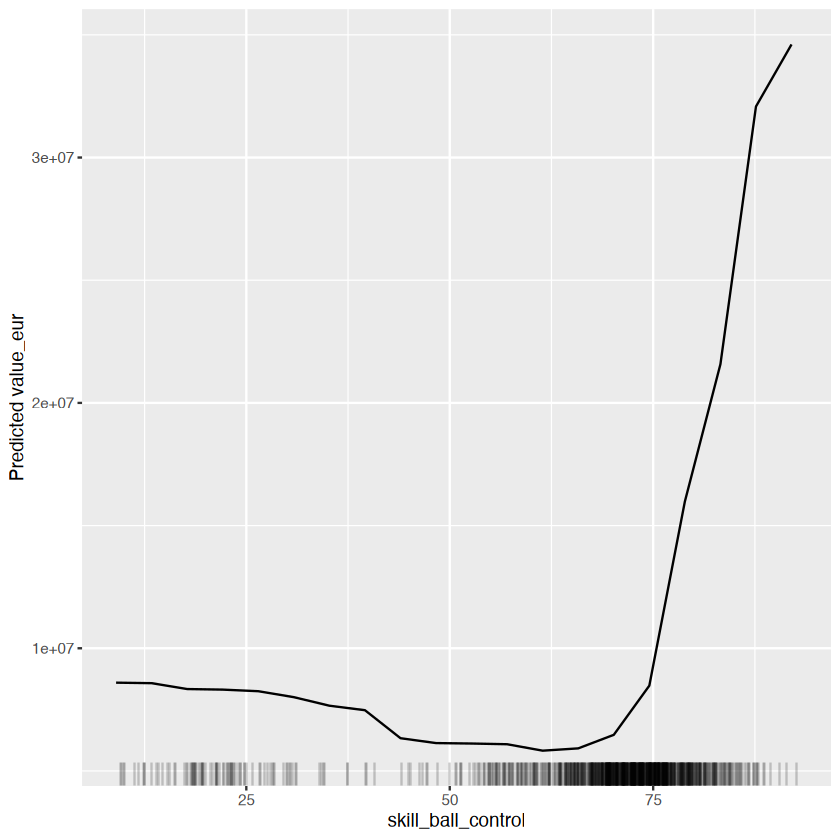

In [61]:
effect_pdp <- FeatureEffect$new(
  predictor,
  feature = "skill_ball_control",
  method = "pdp"
)
effect_pdp$plot()

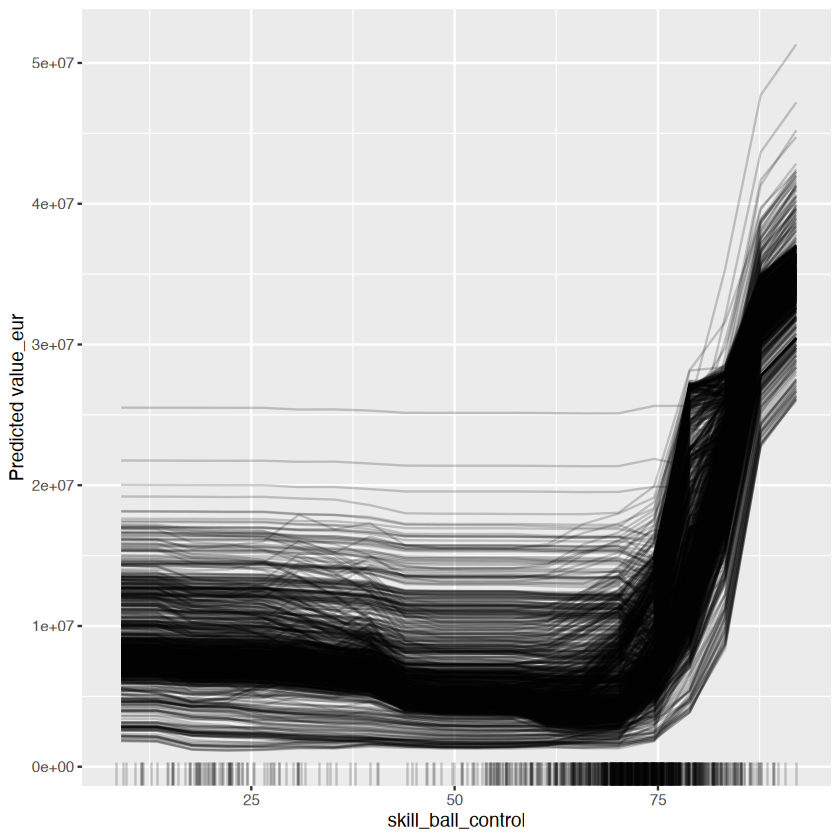

In [62]:
effect_ice <- FeatureEffect$new(
  predictor,
  feature = "skill_ball_control",
  method = "ice"
)
effect_ice$plot()

## 练习4

In [63]:
head(fifa)

,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,95,...,75,96,33,37,26,6,11,15,14,8
Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,94,...,85,95,28,32,24,7,11,15,14,11
Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,87,...,90,94,27,26,29,9,9,15,15,11
J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,11,...,11,68,27,12,18,87,92,78,90,89
E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,84,...,88,91,34,27,22,11,12,6,8,8
K. De Bruyne,Belgium,91,91,370000,90000000,28,181,70,93,82,...,79,91,68,58,51,15,13,5,10,13


In [67]:
head(fifa)

,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,95,...,75,96,33,37,26,6,11,15,14,8
Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,94,...,85,95,28,32,24,7,11,15,14,11
Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,87,...,90,94,27,26,29,9,9,15,15,11
J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,11,...,11,68,27,12,18,87,92,78,90,89
E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,84,...,88,91,34,27,22,11,12,6,8,8
K. De Bruyne,Belgium,91,91,370000,90000000,28,181,70,93,82,...,79,91,68,58,51,15,13,5,10,13


In [76]:
# 找出Manuel Neuer的索引
rownames <- row.names(fifa)
index <- which(rownames == "M. Neuer")
print(index)

[1] 32


In [ ]:
Neuer <- tsk_fifa$data(rows = 32, cols = tsk_fifa$feature_names)

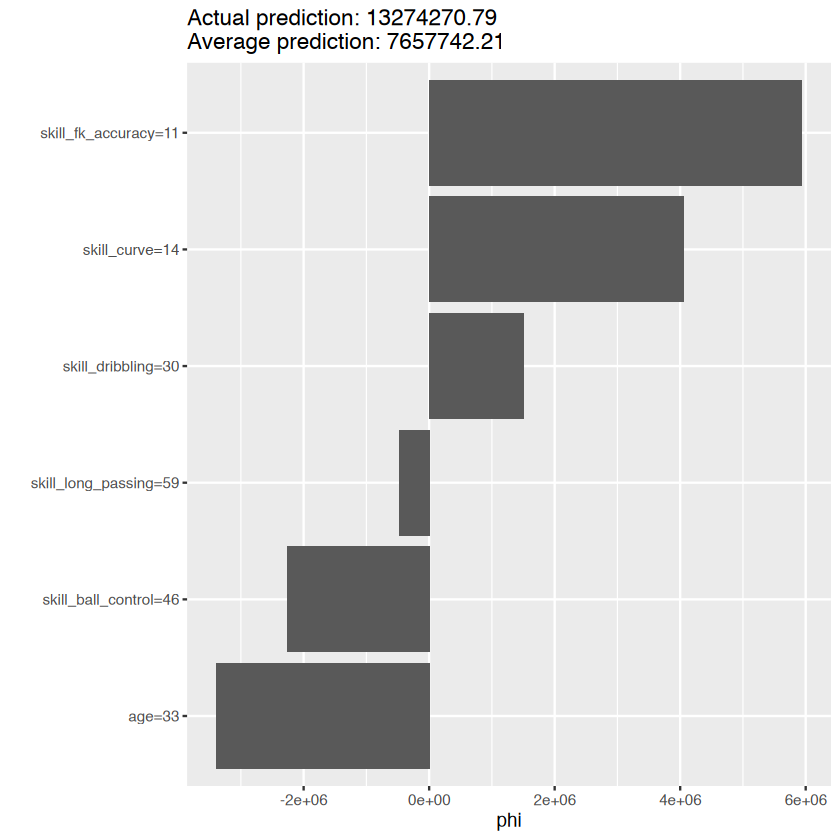

In [78]:
shapley <- Shapley$new(
  predictor,
  x.interest = as.data.frame(Neuer),
  sample.size = 1000
)
shapley$plot()

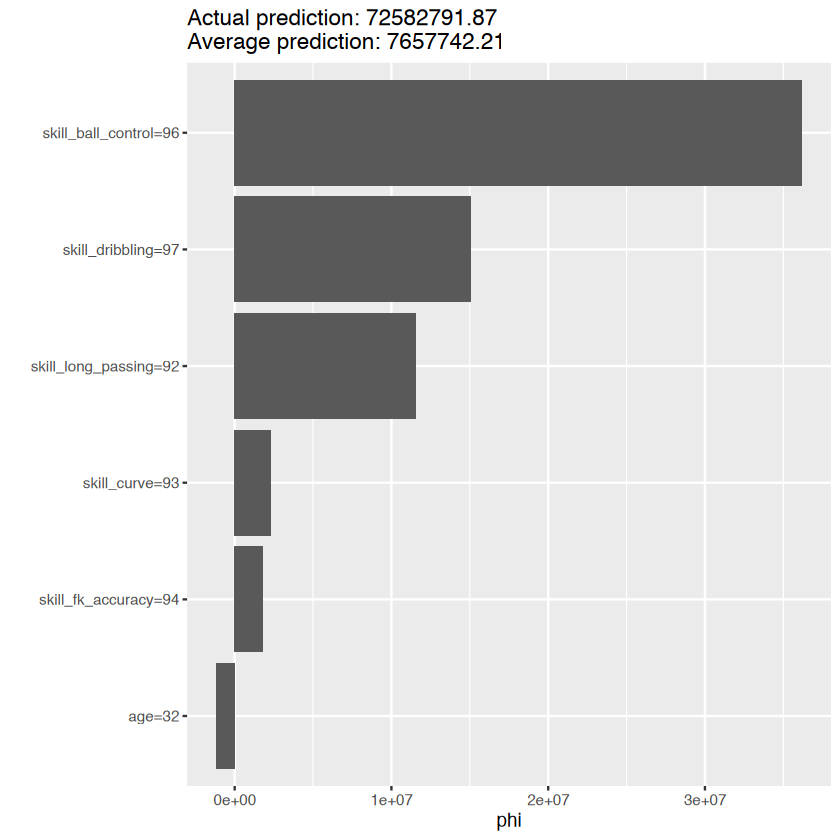

In [79]:
Messi <- tsk_fifa$data(rows = 1, cols = tsk_fifa$feature_names)

shapley <- Shapley$new(
  predictor,
  x.interest = as.data.frame(Messi),
  sample.size = 1000
)
shapley$plot()

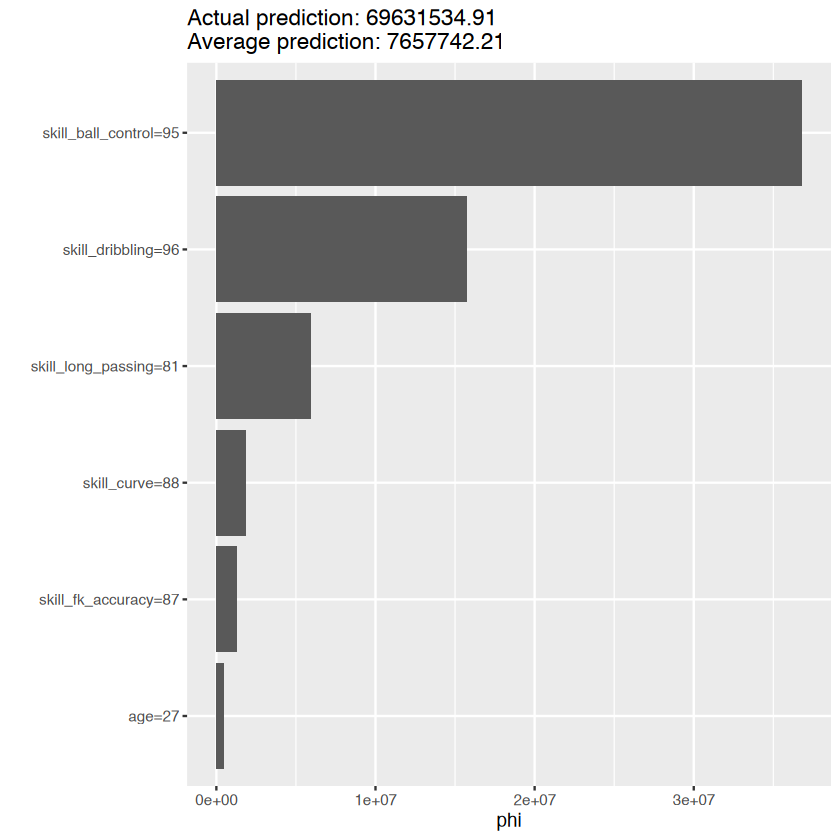

In [80]:
Neymar <- tsk_fifa$data(rows = 3, cols = tsk_fifa$feature_names)

shapley <- Shapley$new(
  predictor,
  x.interest = as.data.frame(Neymar),
  sample.size = 1000
)
shapley$plot()

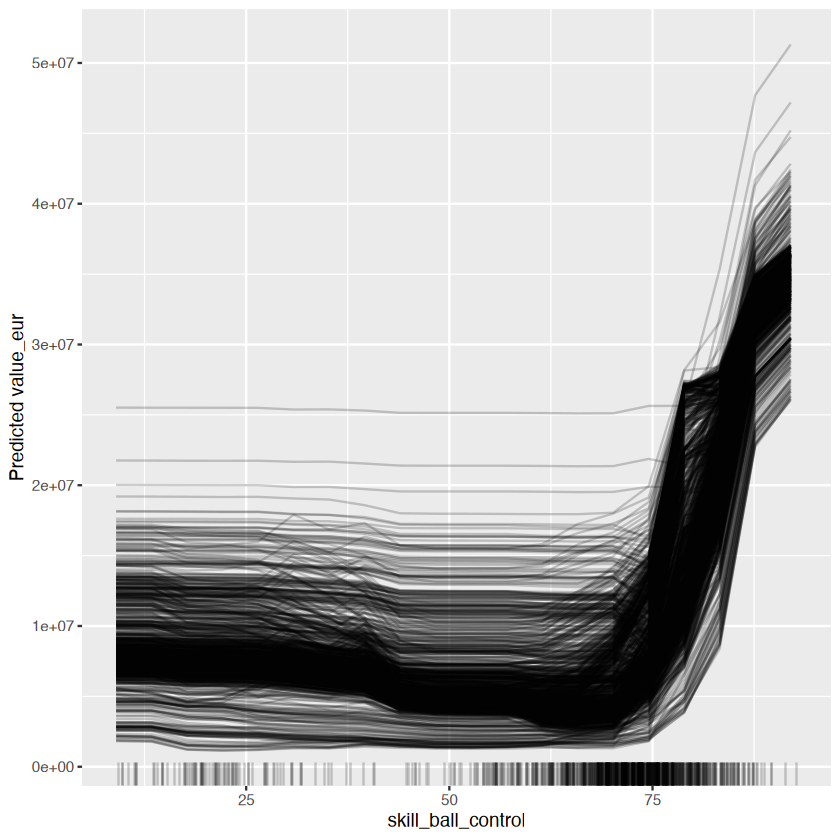

In [88]:
# 只画第一个样本的 CP 曲线
effect_single <- FeatureEffect$new(
  predictor,
  feature = "skill_ball_control",
  method = "ice",
)
plot(effect_single)

考虑到imp包的特征效应并不关注局部，因此我们再补充一个DALEX的结果

In [89]:
library(DALEX)
library(DALEXtra)

ranger_exp <- DALEXtra::explain_mlr3(
  lrn_ranger,
  data = test_features,
  y = as.numeric(test_target$value_eur),
  label = "Ranger FIFA",
  colorize = FALSE
)

Preparation of a new explainer is initiated
  -> model label       :  Ranger FIFA 
  -> data              :  1000  rows  6  cols 
  -> target variable   :  1000  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.23.0 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  1222938 , mean =  7657742 , max =  50968771  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -22500797 , mean =  -165312.2 , max =  49952773  
  A new explainer has been created!  


In [ ]:
performance <- model_performance(ranger_exp)
performance

# Measures for:  regression
# mse        : 3.771633e+13 
# rmse       : 6141362 
# r2         : 0.550958 
# mad        : 1893135

# Residuals:
#          0%         10%         20%         30%         40%         50% 
# -22500797.3  -4554765.3  -2929557.9  -2008753.3  -1397941.8   -945271.7 
#         60%         70%         80%         90%        100% 
#   -481242.6    331760.4   1456456.6   3910670.8  49952772.9

Measures for:  regression
mse        : 3.771633e+13 
rmse       : 6141362 
r2         : 0.550958 
mad        : 1893135

Residuals:
         0%         10%         20%         30%         40%         50% 
-22500797.3  -4554765.3  -2929557.9  -2008753.3  -1397941.8   -945271.7 
        60%         70%         80%         90%        100% 
  -481242.6    331760.4   1456456.6   3910670.8  49952772.9 

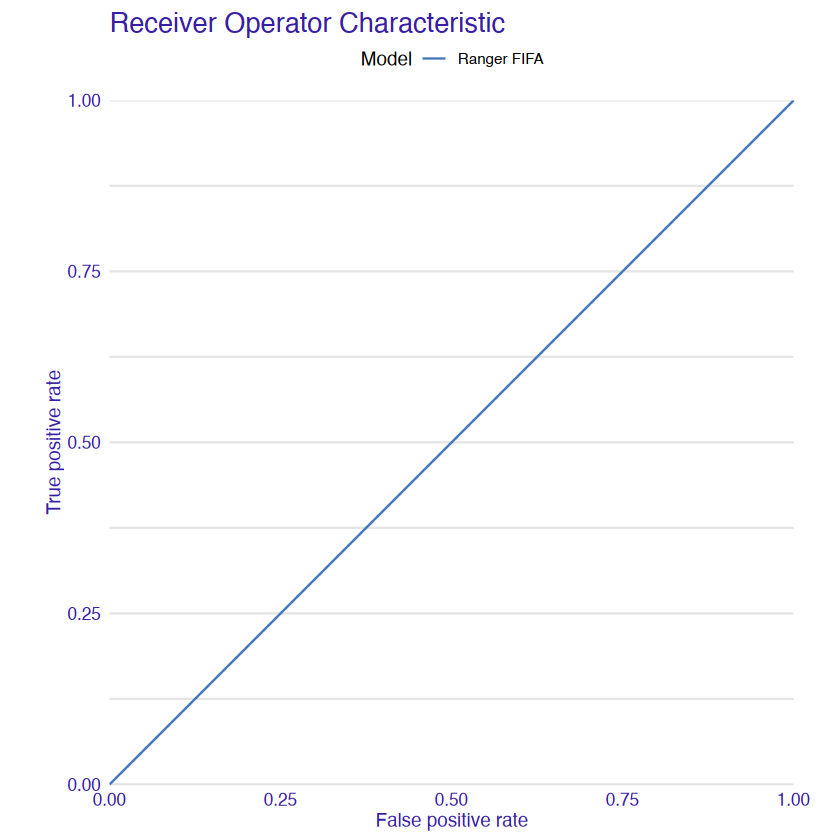

In [91]:
plot(performance, geom = "roc")

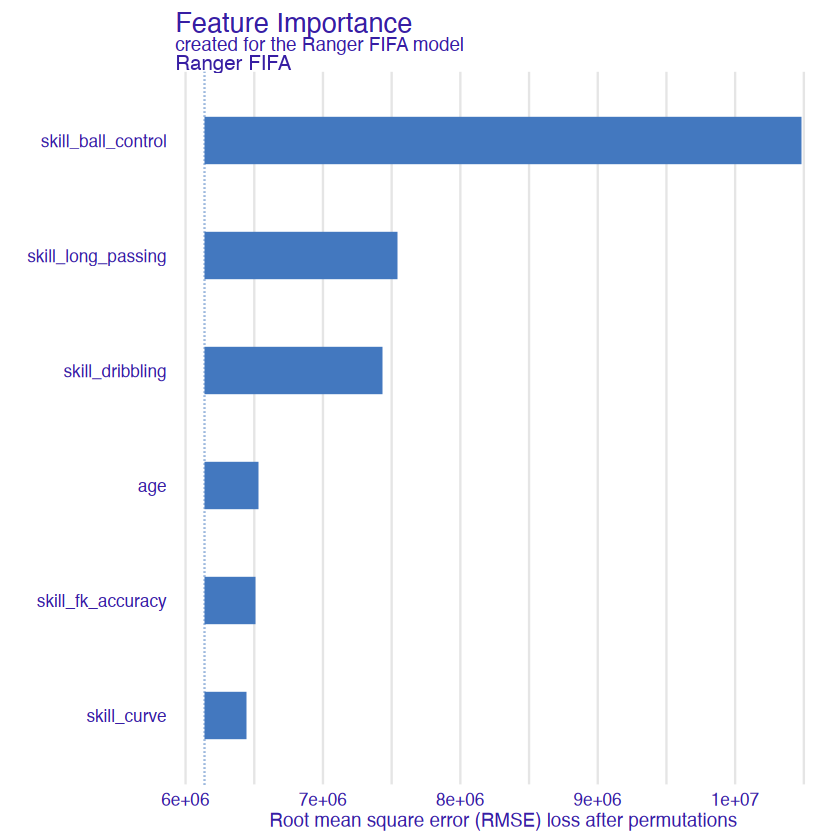

In [94]:
ranger_effect <- model_parts(ranger_exp)
plot(ranger_effect, show_boxplots = FALSE)

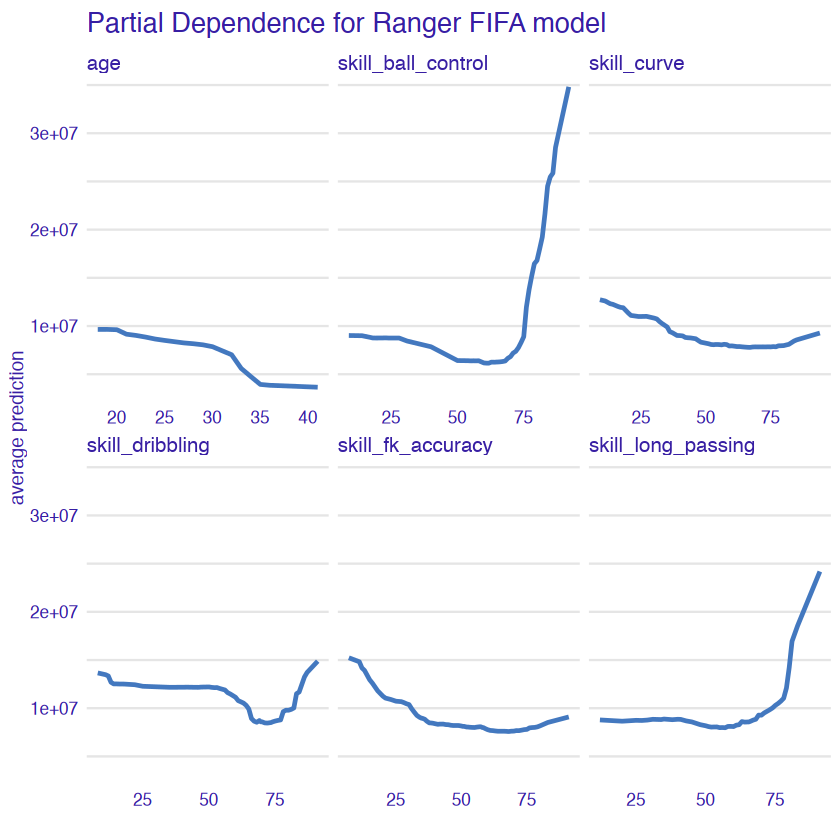

In [95]:
ranger_profiles <- model_profile(ranger_exp)
plot(ranger_profiles) +
  theme(legend.position = "top") +
  ggtitle("Partial Dependence for Ranger FIFA model", "")

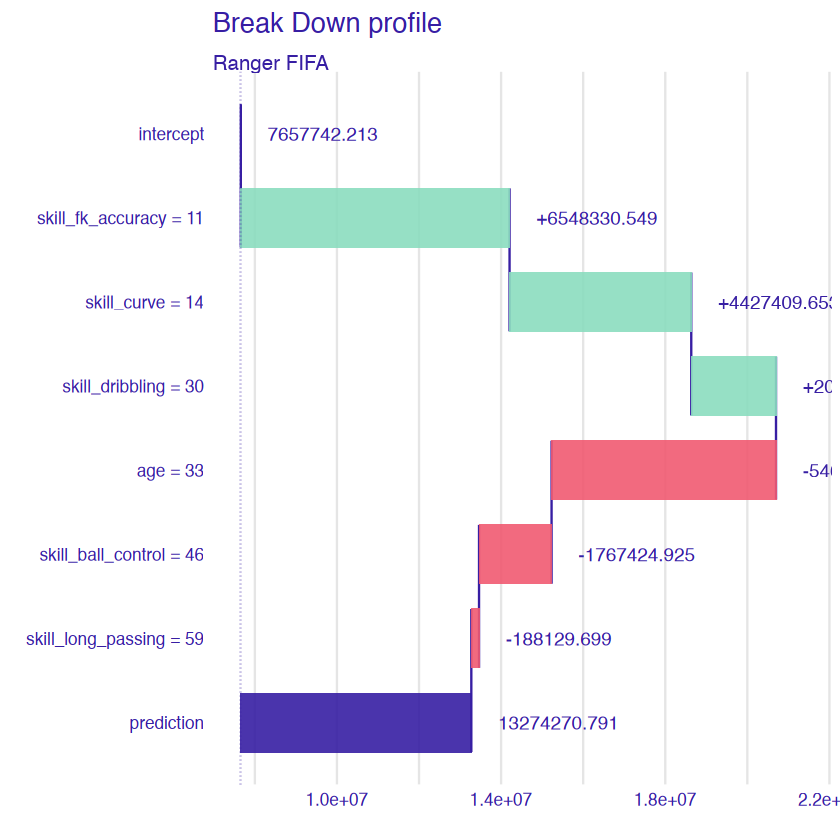

In [99]:
plot(predict_parts(ranger_exp, new_observation = Neuer))

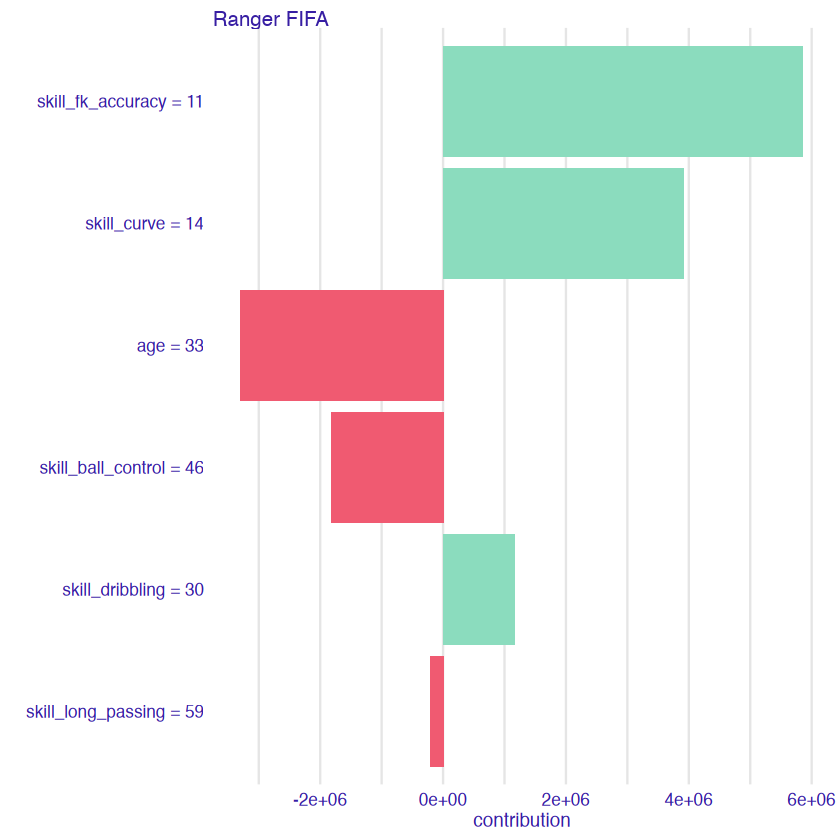

In [100]:
plot(
  predict_parts(
    ranger_exp,
    new_observation = Neuer,
    type = "shap"
  ),
  show_boxplots = FALSE
)

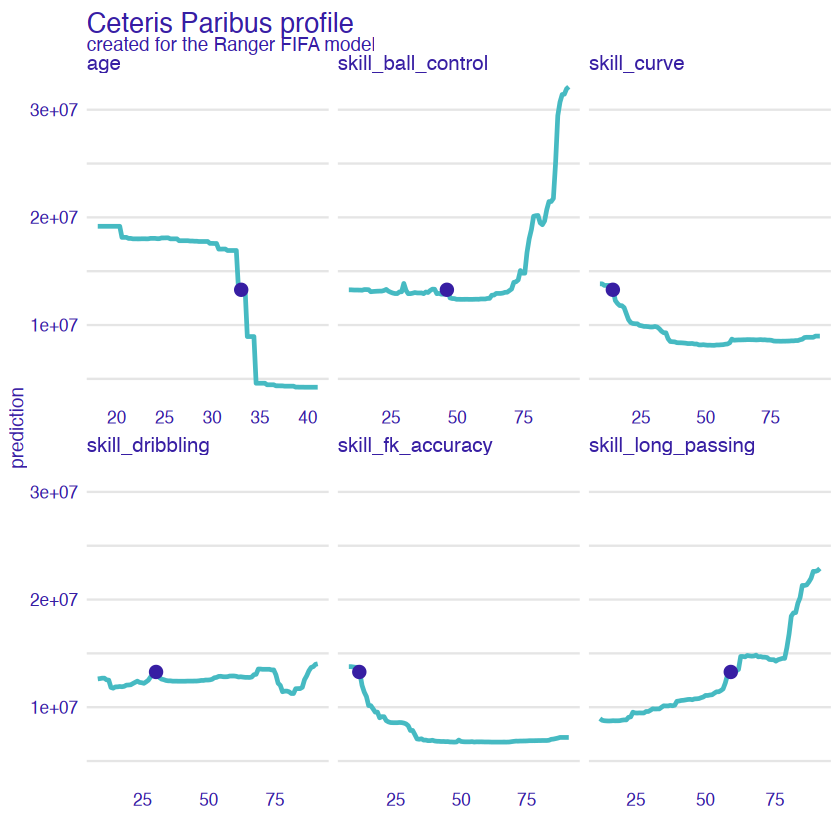

In [101]:
plot(predict_profile(ranger_exp,  Neuer))